In [85]:
%reset -f
import gc
gc.collect()

32237

In [86]:
import numpy as np
import tensorflow as tf
from scipy.fftpack import dct
import math

np.random.seed(42)

In [87]:
# (x, y, z, w) --> (1, 2, 3, 4)
global z0
global w0

w0 = 4
z0 = 3

n = 27
q = 7

num_samples = 1000

In [88]:
def next_power_of_two(x):
    return 2 ** math.ceil(math.log2(x))

n_padded = next_power_of_two(n)

x_original = np.random.randint(0, q, size=(num_samples, n))

padding = n_padded - n
dataset = np.pad(x_original, ((0, 0), (0, padding)), mode='constant', constant_values=0)

print(f"Original n: {n}, Padded to: {n_padded}")

Original n: 27, Padded to: 32


In [89]:
dataset.shape

(1000, 32)

In [90]:
from sklearn.model_selection import train_test_split

y_train, y_val = train_test_split(
    dataset,
    test_size=0.2,
    shuffle=True,
    random_state=42
)

In [91]:
print(y_train.shape)
print(y_val.shape)

(800, 32)
(200, 32)


In [92]:
print(y_train)

[[1 1 2 ... 0 0 0]
 [5 3 6 ... 0 0 0]
 [1 4 3 ... 0 0 0]
 ...
 [3 6 5 ... 0 0 0]
 [1 5 1 ... 0 0 0]
 [3 3 6 ... 0 0 0]]


In [93]:
print(y_val)

[[5 6 5 ... 0 0 0]
 [1 4 1 ... 0 0 0]
 [2 6 0 ... 0 0 0]
 ...
 [6 4 3 ... 0 0 0]
 [2 3 4 ... 0 0 0]
 [4 3 6 ... 0 0 0]]


Encode using generator matrix
$$
\tilde{M}_{kj} = \left[ \left( \frac{w_0}{z_0} \right)^j \zeta^{kj} \right]_{k,j=0}^{n-1}
$$

In [94]:
def padded_generator_matrix(N, w0, z0):
    n = np.arange(N)
    k = n.reshape((N, 1))
    zeta = np.exp(-2j * np.pi / N)
    M_tilde = ((w0 / z0) ** n) * (zeta ** (k * n))
    return M_tilde

In [95]:
M_tilde = padded_generator_matrix(n_padded, w0, z0)
print(M_tilde.shape)

(32, 32)


In [96]:
class FirstLayer(tf.keras.layers.Layer):
    def __init__(self, units, trainable=True, **kwargs):
        super(FirstLayer, self).__init__(**kwargs)
        self.n = units
        self.n1 = units // 2
        self.trainable = trainable

        init_diag = tf.ones(self.n1, dtype=tf.float32)
        init_diag = tf.tensor_scatter_nd_update(init_diag, [[0]], [tf.sqrt(2.0)])

        self.B_1 = self.add_weight(
                shape=(self.n1,),
                initializer=tf.keras.initializers.Constant(init_diag),
                trainable=self.trainable,
                name='B_1'
            )
        self.B_2 = self.add_weight(
                shape=(self.n1,),
                initializer='ones',
                trainable=self.trainable,
                name='B_2'
            )
        self.bias = self.add_weight(
            shape=(self.n,),
            initializer='zeros',
            trainable=True,
            name='bias'
        )

    def call(self, x):
        even = x[:, ::2]
        odd = x[:, 1::2]

        d1 = tf.multiply(odd, self.B_1) # diagonal
        d2 = tf.multiply(tf.concat([tf.zeros_like(odd[:, :1]), odd[:, :-1]], axis=1), self.B_2) # off-diagonal
        B_n = tf.add(d1, d2)

        u = tf.concat([even, B_n], axis=1)

        return u + self.bias

In [97]:
class DCTIII(tf.keras.layers.Layer):
    def __init__(self, n, trainable=True, **kwargs):
        super(DCTIII, self).__init__(**kwargs)
        self.n = n
        self.n1 = n // 2 if n > 2 else 1
        self.trainable = trainable

        if n == 2:
            # Base case: trainable 2x2 matrix
            self.C_2 = self.add_weight(
                shape=(2, 2),
                initializer=tf.keras.initializers.Constant((1 / np.sqrt(2)) * np.array([[1., 1.], [1., -1.]])),
                trainable=self.trainable,
                name='C_2'
            )
        else:
            init_diag = tf.ones(self.n1, dtype=tf.float32)
            init_diag = tf.tensor_scatter_nd_update(init_diag, [[0]], [tf.sqrt(2.0)])

            # Weights for B^T_{n/2}
            self.B_1 = self.add_weight(
                shape=(self.n1,),
                initializer=tf.keras.initializers.Constant(init_diag),
                trainable=self.trainable,
                name='B_1'
            )
            self.B_2 = self.add_weight(
                shape=(self.n1,),
                initializer='ones',
                trainable=self.trainable,
                name='B_2'
            )

            k = tf.cast(tf.range(1, self.n1 + 1), tf.float32)
            pi = tf.constant(np.pi, dtype=tf.float32)
            init_W_c = 1 / (2 * tf.cos((2 * k - 1) * (pi / (2 * self.n))))

            # Weight for W_c
            self.w_c = self.add_weight(
                shape=(self.n1,),
                initializer=tf.keras.initializers.Constant(init_W_c),
                trainable=self.trainable,
                name='W_c'
            )
            # Recursive DCTIII for n/2
            self.dctiii_layer1 = DCTIII(self.n1,trainable=self.trainable)
            self.dctiii_layer2 = DCTIII(self.n1,trainable=self.trainable)

    def call(self, x):
        if self.n == 2:
            y = tf.matmul(self.C_2, x, transpose_b=True)
            return tf.transpose(y)
        else:
            # Permutation
            even = x[:, ::2]
            odd = x[:, 1::2]

            # B^T
            d1 = tf.multiply(odd, self.B_1)
            d2 = tf.multiply(tf.concat([tf.zeros_like(odd[:, :1]), odd[:, :-1]], axis=1), self.B_2)
            B_n = tf.add(d1, d2)
            u = tf.concat([even, B_n], axis=1)

            # Recursive DCTIII
            z1 = self.dctiii_layer1(u[:, :self.n1])
            z2 = self.dctiii_layer2(u[:, self.n1:])
            recurs_out = tf.concat([z1, z2], axis=1)

            # W_c
            W_n = tf.multiply(recurs_out[:, self.n1:], self.w_c)
            v = tf.concat([recurs_out[:, :self.n1], W_n], axis=1)

            # H_n
            out1 = v[:, :self.n1]
            out2 = v[:, self.n1:]
            y = (1 / tf.sqrt(tf.constant(2.0, dtype=tf.float32))) * tf.concat(
                [(out1 + out2), tf.reverse((out1 - out2), axis=[1])],
                axis=1
            )

            return y

In [98]:
class SecondLayer(tf.keras.layers.Layer):
    def __init__(self, units, trainable=True, **kwargs):
        super(SecondLayer, self).__init__(**kwargs)
        self.n = units
        self.n1 = units // 2
        self.trainable = trainable

        self.bias = self.add_weight(
            shape=(self.n,),
            initializer='zeros',
            trainable=True,
            name='bias'
        )

        self.dctiii1 = DCTIII(self.n1, trainable=self.trainable)
        self.dctiii2 = DCTIII(self.n1,trainable=self.trainable)

    def call(self, x):
        z1 = self.dctiii1(x[:, :self.n1])
        z2 = self.dctiii2(x[:, self.n1:])
        out = tf.concat([z1, z2], axis=1)
        return out + self.bias

In [99]:
class ThirdLayer(tf.keras.layers.Layer):
    def __init__(self, units, trainable=True, **kwargs):
        super(ThirdLayer, self).__init__(**kwargs)
        self.n = units
        self.n1 = units // 2
        self.trainable = trainable

        k = tf.cast(tf.range(1, self.n1 + 1), tf.float32)
        pi = tf.constant(np.pi, dtype=tf.float32)
        init_W_c = 1 / (2 * tf.cos((2 * k - 1) * (pi / (2 * self.n))))

        self.w_c = self.add_weight(
                shape=(self.n1,),
                initializer=tf.keras.initializers.Constant(init_W_c),
                trainable=self.trainable,
                name='W_c'
            )

        self.bias = self.add_weight(
            shape=(self.n,),
            initializer='zeros',
            trainable=True,
            name='bias'
        )

    def call(self, x):
        input1 = x[:, :self.n1]
        input2 = x[:, self.n1:]

        # W_{N/2}
        W_n = tf.multiply(input2, self.w_c)
        v = tf.concat([input1, W_n], axis=1)

        # H_n^T
        out1 = v[:, :self.n1]
        out2 = v[:, self.n1:]

        y = (1 / tf.sqrt(tf.constant(2.0, dtype=tf.float32))) * tf.concat([(out1 + out2), tf.reverse((out1 - out2), axis=[1])], axis=1)

        # y = self.h * tf.concat([(out1 + out2), tf.reverse((out1 - out2), axis=[1])], axis=1)

        return y + self.bias

In [100]:
class DiagonalLayer(tf.keras.layers.Layer):
    def __init__(self, units, trainable=True, kernel_initializer='he_normal', bias_initializer='zeros', **kwargs):
        super(DiagonalLayer, self).__init__(**kwargs)
        self.units = units
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.trainable = trainable

    def build(self, input_shape):
        self.diag = self.add_weight(
            shape=(self.units,),
            initializer=tf.keras.initializers.get(self.kernel_initializer),
            trainable=self.trainable,
            name='diag'
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer=tf.keras.initializers.get(self.bias_initializer),
            trainable=self.trainable,
            name='bias'
        )

    def call(self, inputs):
        scaled = tf.multiply(inputs, self.diag)
        return scaled + self.bias

In [101]:
class ScalingLayer(tf.keras.layers.Layer):
    def __init__(self, units, initial_scale=1.0, trainable=True, kernel_initializer='he_normal', bias_initializer='zeros', **kwargs):
        super(ScalingLayer, self).__init__(**kwargs)
        self.units = units
        self.initial_scale = initial_scale
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer

    def build(self, input_shape):

      self.log_scale = self.add_weight(
          shape=(),
          initializer=tf.keras.initializers.Constant(self.initial_scale),
          trainable=True,
          name="log_scale",
      )
      self.diag = self.add_weight(
          shape=(self.units,),
          initializer=tf.keras.initializers.get(self.kernel_initializer),
          regularizer=tf.keras.regularizers.l2(1e-4),
          trainable=True,
          name='diag'
      )
      self.bias = self.add_weight(
          shape=(self.units,),
          initializer=tf.keras.initializers.get(self.bias_initializer),
          trainable=True,
          name='bias'
        )

      super().build(input_shape)

    def call(self, inputs):
      perm = tf.concat([inputs[:, ::2], inputs[:, 1::2][:, ::-1]], axis=-1)

      dim = tf.shape(perm)[1]

      D_hat_n = tf.exp(self.log_scale * tf.cast(tf.range(dim), tf.float32))

      scaled = perm * D_hat_n * self.diag

      return scaled + self.bias

In [102]:
def custom_accuracy(y_true, y_pred):
    y_true_int = tf.cast(y_true * (q - 1), tf.int32)  # Rescale from [0,1] to [0, q-1]
    y_pred_int = tf.cast(tf.round(y_pred * (q - 1)), tf.int32)
    mask = tf.concat(
        [tf.ones((tf.shape(y_true)[0], n), dtype=tf.float32),
         tf.zeros((tf.shape(y_true)[0], n_padded - n), dtype=tf.float32)],
        axis=1
    )
    correct = tf.cast(tf.equal(y_true_int, y_pred_int), tf.float32) * mask
    return tf.reduce_sum(correct) / tf.reduce_sum(mask)

def custom_mse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    loss = tf.reduce_mean(tf.square(tf.cast(y_true - y_pred, tf.float32)))
    return loss

In [103]:
from tensorflow.keras.layers import InputLayer, LeakyReLU, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

initial_log_scale = np.log(z0 / w0)
initial_scale = (z0 / w0)

input_shape = (n_padded,)
model = Sequential([
    InputLayer(shape=input_shape),
    FirstLayer(units=n_padded, trainable=True, name="first_layer"),
    # Activation('linear'),
    SecondLayer(units=n_padded, trainable=True, name="second_layer"),
    # Activation('linear'),
    ThirdLayer(units=n_padded, trainable=True, name="third_layer"),
    LeakyReLU(negative_slope=0.1),
    ScalingLayer(units=n_padded, initial_scale=initial_log_scale, kernel_initializer='ones', bias_initializer='zeros', name="scaling_layer"),
    LeakyReLU(negative_slope=0.1),
    DiagonalLayer(units=n_padded, trainable=False, kernel_initializer='ones', bias_initializer='zeros', name="output_layer"),
    Activation('linear')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mse', custom_accuracy]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ first_layer (FirstLayer)             │ (None, 32)                  │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_layer (SecondLayer)           │ (None, 32)                  │             240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ third_layer (ThirdLayer)             │ (None, 32)                  │              48 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ scaling_layer (ScalingLayer)         │ (None, 32)                  │              65 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (DiagonalLayer)         │ (None, 32)                  │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 417 (1.63 KB)

 Non-trainable params: 64 (256.00 B)

In [104]:
def batch_generator(train_dataset, M_tilde, q, batch_size, sigma):
    n = train_dataset.shape[1]
    k = np.arange(n)
    alpha_k = np.where(k == 0, np.sqrt(1/n), np.sqrt(2/n))
    shift = np.exp(-1j * np.pi * k / (2 * n))

    # indices = np.arange(len(train_dataset))
    # i = 0

    while True:
        # if i + batch_size > len(train_dataset):
            # np.random.shuffle(indices)  # Shuffle for next epoch
            # i = 0

        # idx = indices[i:i+batch_size]
        # i += batch_size

        # x_batch = train_dataset[idx]

        idx = np.random.choice(len(train_dataset), size=batch_size)
        x_batch = train_dataset[idx]

        # y = Mx ---> shape: (batch_size, n)
        y_batch = np.dot(M_tilde, x_batch.T).T

        # add noise to simulate a noisy channel
        noise = np.random.normal(0, sigma, y_batch.shape)
        y_noisy = y_batch + noise

        # convert to DCT-II coefficients
        dct2_batch = np.real(alpha_k * shift * y_noisy)
        dct2_batch = np.round(dct2_batch, decimals=10)

        # normalize
        dct2_batch = (dct2_batch - dct2_batch.mean()) / dct2_batch.std()
        y_scaled = x_batch / (q - 1)

        yield dct2_batch.astype(np.float32), y_scaled.astype(np.float32)

In [105]:
# preparing the validation data

val_encoded = np.dot(M_tilde, y_val.T).T

k = np.arange(n_padded)
alpha_k = np.where(k == 0, np.sqrt(1/n_padded), np.sqrt(2/n_padded))
shift = np.exp(-1j * np.pi * k / (2 * n_padded))
X_val_dct2 = np.real(alpha_k * shift * val_encoded)
X_val_dct2 = (X_val_dct2 - X_val_dct2.mean()) / X_val_dct2.std()

y_val_labels = y_val / (q - 1)

X_val_dct2 = X_val_dct2.astype(np.float32)
y_val_labels = y_val_labels.astype(np.float32)

In [106]:
# y_train
# y_val
# y_val_labels
# X_val_dct2

In [107]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

adjust_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

history = model.fit(
    batch_generator(y_train, M_tilde, q=q, batch_size=64, sigma=0.05),
    steps_per_epoch=100,
    epochs=200,
    validation_data=(X_val_dct2, y_val_labels),
    callbacks=[adjust_lr, early_stopping]
)

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step - custom_accuracy: 0.1407 - loss: 0.2577 - mse: 0.2545 - val_custom_accuracy: 0.1483 - val_loss: 0.1644 - val_mse: 0.1611 - learning_rate: 0.0010
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - custom_accuracy: 0.1538 - loss: 0.1376 - mse: 0.1342 - val_custom_accuracy: 0.1954 - val_loss: 0.0694 - val_mse: 0.0657 - learning_rate: 0.0010
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - custom_accuracy: 0.2311 - loss: 0.0678 - mse: 0.0641 - val_custom_accuracy: 0.2665 - val_loss: 0.0648 - val_mse: 0.0612 - learning_rate: 0.0010
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - custom_accuracy: 0.2759 - loss: 0.0643 - mse: 0.0607 - val_custom_accuracy: 0.2988 - val_loss: 0.0619 - val_mse: 0.0582 - learning_rate: 0.0010
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - custom_accuracy: 0.3038 - loss: 0.0609 - mse: 0.0572 - val_custom_accuracy: 0.3193 - val_loss: 0.0594 - val_mse: 0.0558 - learning_rate: 0.0010
Ep

In [108]:
# Evaluate the model on the test set
eval_results = model.evaluate(X_val_dct2, y_val_labels)
print(f"Test results - Loss: {eval_results[0]}, MSE: {eval_results[1]}, Accuracy: {eval_results[2]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - custom_accuracy: 0.7454 - loss: 0.0241 - mse: 0.0221 
Test results - Loss: 0.024434909224510193, MSE: 0.022473029792308807, Accuracy: 0.7407407760620117


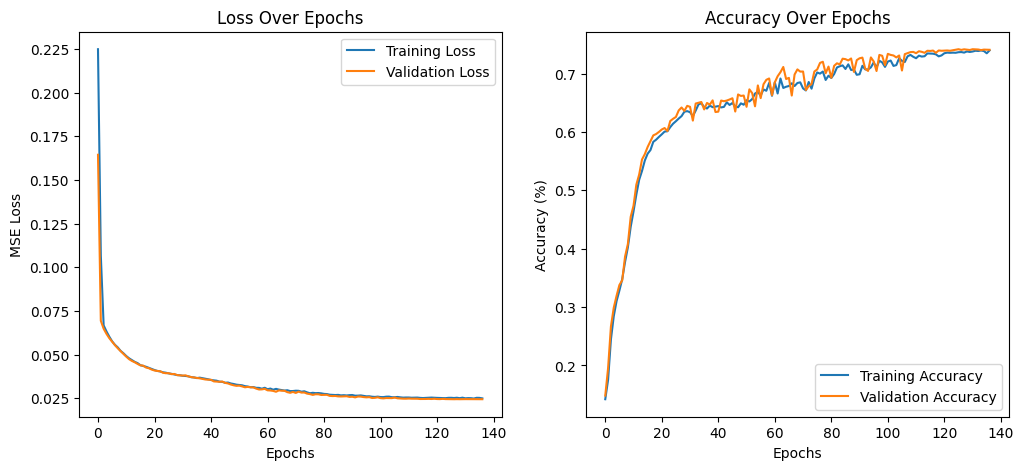

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['custom_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_custom_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [110]:
from sklearn.metrics import r2_score

y_pred = model.predict(X_val_dct2)

r2 = r2_score(y_val_labels, y_pred)

print(f"R² Score: {r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 265ms/step
R² Score: 0.6412


In [111]:
y_pred = model.predict(X_val_dct2)
y_pred_rescaled = y_pred * (q - 1)

print("Comparison of predictions and ground truth:")
for i in range(3):
    print(f"Sample {i+1}:")
    print(f"  Predicted:    {np.round(y_pred_rescaled[i]).astype(int)}")
    print(f"  Ground Truth: {y_val[i].astype(int)}")
    print("-" * 40)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Comparison of predictions and ground truth:
Sample 1:
  Predicted:    [3 3 3 3 3 3 2 2 5 2 3 1 4 0 3 2 5 1 4 3 4 4 6 5 2 3 1 0 0 0 0 0]
  Ground Truth: [5 6 5 1 3 4 1 1 6 2 3 1 4 0 3 2 5 1 4 3 4 4 6 5 2 3 1 0 0 0 0 0]
----------------------------------------
Sample 2:
  Predicted:    [3 3 3 3 3 3 3 4 4 2 4 3 3 1 3 1 1 2 0 1 1 5 2 1 4 0 4 0 0 0 0 0]
  Ground Truth: [1 4 1 3 3 3 0 5 5 2 4 3 3 1 3 1 1 2 0 1 1 5 2 1 4 0 4 0 0 0 0 0]
----------------------------------------
Sample 3:
  Predicted:    [3 3 3 3 3 3 3 4 2 6 4 1 0 5 2 3 5 1 4 6 0 4 3 2 3 4 4 0 0 0 0 0]
  Ground Truth: [2 6 0 2 2 1 3 4 2 6 4 1 0 5 2 3 5 1 4 6 0 4 3 2 3 4 4 0 0 0 0 0]
----------------------------------------


In [119]:
num_unseen_samples = 20
x_unseen_original = np.random.randint(0, q, size=(num_unseen_samples, n))
x_unseen_original_padded = np.pad(x_unseen_original, ((0, 0), (0, padding)), mode='constant', constant_values=0)

encoded_dataset_unseen = np.array([np.dot(M_tilde, x) for x in x_unseen_original_padded])
encoded_dataset_unseen[np.abs(encoded_dataset_unseen) < 1e-10] = 0
encoded_dataset_unseen = np.round(encoded_dataset_unseen, decimals=10)

# add some noise to simulate channel distortion
noise_ratio = 0.05
real_parts = np.real(encoded_dataset_unseen)
imag_parts = np.imag(encoded_dataset_unseen)
noise_std_real = np.abs(real_parts) * noise_ratio
noise_std_imag = np.abs(imag_parts) * noise_ratio
noise_real = np.random.normal(0, noise_std_real, size=encoded_dataset_unseen.shape)
noise_imag = np.random.normal(0, noise_std_imag, size=encoded_dataset_unseen.shape)
noise = noise_real + 1j * noise_imag

# Add noise to the original data
encoded_noisy = encoded_dataset_unseen + noise

print(encoded_dataset_unseen[0])
print("\n")
print(encoded_noisy[0])

[ 23477.5885329     +0.j          -1148.19286514+20506.02208415j
 -15884.57004076  +817.19610968j  -2952.68056168-11877.39372372j
   6882.37700825 -3879.93572511j   5506.80079231 +1509.77467339j
   2197.70727923 +6690.69152199j  -6742.7461178  +4797.28961305j
  -6282.29195171 -6155.15780497j   4755.89320912 -6095.84709376j
   5869.39624311 +2238.39642393j   -912.20541743 +5598.69524192j
  -4029.79613456  -644.62582004j   -174.72462939 -1483.21718922j
    263.60325107 -1200.75538802j    909.65917528   -27.78160613j
    165.95298732    +0.j            909.65917528   +27.78160613j
    263.60325107 +1200.75538802j   -174.72462939 +1483.21718922j
  -4029.79613456  +644.62582004j   -912.20541743 -5598.69524192j
   5869.39624311 -2238.39642393j   4755.89320912 +6095.84709376j
  -6282.29195171 +6155.15780497j  -6742.7461178  -4797.28961305j
   2197.70727923 -6690.69152199j   5506.80079231 -1509.77467339j
   6882.37700825 +3879.93572511j  -2952.68056168+11877.39372372j
 -15884.57004076  -817.19

In [120]:
# projection to get real-valued DCT-2 like input
N = encoded_dataset_unseen.shape[1]

k = np.arange(N)
shift = np.exp(-1j * np.pi * k / (2 * N))
alpha_k = np.where(k == 0, np.sqrt(1/N), np.sqrt(2/N))

x_unseen_dct2 = np.array([np.real(alpha_k * shift * y) for y in encoded_dataset_unseen])
x_unseen_dct2[np.abs(x_unseen_dct2) < 1e-10] = 0
x_unseen_dct2 = np.round(x_unseen_dct2, decimals=10) # Round for numerical stability

x_unseen_dct2_noisy = np.array([np.real(alpha_k * shift * y) for y in encoded_noisy])
x_unseen_dct2_noisy[np.abs(x_unseen_dct2_noisy) < 1e-10] = 0
x_unseen_dct2_noisy = np.round(x_unseen_dct2_noisy, decimals=10) # Round for numerical stability

print(x_unseen_dct2[0])
print("\n")
print(x_unseen_dct2_noisy[0])

[ 4150.29051438   -35.15675079 -3931.99556714 -1165.87446735
  1498.29903846  1427.15354885  1011.31999267 -1183.10859896
 -2039.88946675   423.24151664  1557.87953141   523.96997576
  -927.19698668  -255.97289657  -139.49577137   163.83900081
    29.33662067   157.86864433   273.85614976   271.81196925
  -425.71199921 -1317.78209901   198.18120796  1885.99671766
   820.62381705 -1697.10557881 -1441.15796077   -31.62129282
  1287.01724872  2828.89766284  -592.55530445 -5134.41520902]


[ 4580.9590422    -50.2883796  -4095.28865052 -1155.90172168
  1594.6038321   1456.88978671   988.11183565 -1123.08066139
 -1965.05460564   509.41648012  1540.29892204   495.40853118
  -933.96580364  -255.82431546  -135.94445254   166.54672735
    27.02550747   150.78812658   269.07801593   264.13973266
  -406.61394575 -1323.28536816   157.40888877  1838.45688698
   862.67045651 -1619.14738083 -1356.79169465   -19.48604292
  1379.13794544  2786.29465567  -592.39754356 -5311.10842526]


In [121]:
# classical algorithm
from scipy.fft import ifft

def lrc(y, n, q, r, w0, z0):
    if n >= 2:
        z1 = ifft(y, n)

        D_hat_n = np.diag([(z0 / w0) ** k for k in range(n)])
        z2 = np.dot(D_hat_n, z1)

        J_rxn = np.hstack([np.eye(r), np.zeros((r, n - r))])
        z3 = np.dot(J_rxn, z2)

        z4 = np.abs(z3)

        # z5 = np.ceil(z4)
        z5 = np.round(z4)

        x_tilde = np.mod(z5, q)

        return x_tilde

    return y

In [122]:
############## just to compare with classical dct3 ##############

classical_dct3_pred = np.array([dct(x, type=3, norm='ortho') for x in x_unseen_dct2_noisy])
after_perm = np.hstack((classical_dct3_pred[:, ::2], classical_dct3_pred[:, 1::2][:, ::-1]))
D_hat_n = np.array([(z0 / w0) ** k for k in range(N)])
scaled_dct3_pred = after_perm * D_hat_n

mse_classical_dct3 = custom_mse(x_unseen_original_padded, scaled_dct3_pred)
acc_classical_dct3 = custom_accuracy(x_unseen_original_padded, scaled_dct3_pred)

############## classical algorithm for recovery (here we assume the classical algorithm can also be used for global recovery. just to compare) ##############

classical_pred = np.array([lrc(y=x, n=n_padded, q=q, r=n_padded, w0=w0, z0=z0) for x in encoded_noisy])
mse_classical = custom_mse(x_unseen_original_padded, classical_pred)
acc_classical = custom_accuracy(x_unseen_original_padded, classical_pred)

############## predictions of our StNN ##############

x_unseen_original_padded_normalized = x_unseen_original_padded.astype(np.float32) / (q - 1)  # Scale to [0, 1]

x_unseen_dct2_noisy = (x_unseen_dct2_noisy - x_unseen_dct2_noisy.mean()) / x_unseen_dct2_noisy.std()
nn_pred = model.predict(x_unseen_dct2_noisy)

y_pred_final = np.mod(np.round(nn_pred * (q - 1)), q)

mse_nn = custom_mse(x_unseen_original_padded, y_pred_final)
acc_nn = custom_accuracy(x_unseen_original_padded_normalized, nn_pred)

############## display ##############

print(f"\nClassical DCT-III:")
print(f"  MSE: {mse_classical_dct3}")
print(f"  Accuracy: {acc_classical_dct3}")

print(f"\nClassical Algorithm:")
print(f"  MSE: {mse_classical}")
print(f"  Accuracy: {acc_classical}")

print(f"\nNeural Network:")
print(f"  MSE: {mse_nn}")
print(f"  Accuracy: {acc_nn}")

num_display_samples = 3
for i in range(num_display_samples):
    print(f"\nSample {i+1}:")
    print(f"Original     : {x_unseen_original_padded[i]}")
    print(f"Classical Al : {np.round(classical_pred[i]).astype(int)}")
    print(f"NN Pred      : {np.mod(np.round(nn_pred[i]*(q-1)), q).astype(int)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step

Classical DCT-III:
  MSE: 319.59185791015625
  Accuracy: 0.16851851344108582

Classical Algorithm:
  MSE: 3.676562547683716
  Accuracy: 0.44999998807907104

Neural Network:
  MSE: 2.924999952316284
  Accuracy: 0.5018518567085266

Sample 1:
Original     : [5 4 1 4 3 0 3 5 0 0 1 0 1 1 6 3 1 4 0 1 2 4 6 3 2 5 3 0 0 0 0 0]
Classical Al : [6 5 1 2 2 0 1 5 1 2 6 2 2 2 0 4 2 5 1 1 2 4 6 3 2 5 3 0 0 0 0 0]
NN Pred      : [3 3 3 3 3 3 5 5 1 0 5 0 0 1 0 3 1 5 1 1 2 4 6 3 2 5 3 0 0 0 0 0]

Sample 2:
Original     : [5 3 3 6 6 6 6 4 6 1 3 0 4 0 2 6 6 0 5 5 5 4 6 1 6 1 0 0 0 0 0 0]
Classical Al : [1 0 2 5 1 1 4 6 1 5 2 3 0 1 3 6 5 0 5 5 5 4 6 1 6 1 0 0 0 0 0 0]
NN Pred      : [3 3 3 4 4 4 4 6 5 1 4 2 1 0 0 6 4 1 5 5 5 4 6 1 6 1 0 0 0 0 0 0]

Sample 3:
Original     : [5 3 1 4 0 0 6 6 1 1 1 5 2 3 6 3 4 0 4 4 1 5 4 4 4 0 4 0 0 0 0 0]
Classical Al : [0 1 0 2 5 3 4 4 4 2 2 1 3 5 6 4 4 1 4 4 1 5 4 4 4 0 4 0 0 0 0 0]
NN Pred      : [3 3 3 4 2 2 0 0 0 0 0 2 6 1 1 3 5 

(array([1.488e+03, 5.000e+01, 1.000e+00, 0.000e+00, 8.000e+00, 3.900e+01,
        1.290e+02, 2.760e+02, 1.450e+02, 2.400e+01, 6.000e+00, 2.100e+01,
        1.600e+01, 1.800e+01, 1.230e+02, 2.630e+02, 1.200e+02, 4.500e+01,
        3.000e+01, 3.100e+01, 5.000e+01, 1.160e+02, 3.090e+02, 8.670e+02,
        3.740e+02, 7.600e+01, 3.000e+01, 2.600e+01, 3.200e+01, 6.000e+01,
        1.600e+02, 2.500e+02, 1.160e+02, 1.700e+01, 1.900e+01, 1.400e+01,
        5.000e+00, 2.600e+01, 2.050e+02, 2.290e+02, 8.900e+01, 1.300e+01,
        7.000e+00, 0.000e+00, 3.000e+00, 3.000e+01, 1.640e+02, 1.960e+02,
        6.800e+01, 1.600e+01]),
 array([-5.29898913e-04,  2.09647268e-02,  4.24593501e-02,  6.39539734e-02,
         8.54486004e-02,  1.06943227e-01,  1.28437847e-01,  1.49932474e-01,
         1.71427101e-01,  1.92921728e-01,  2.14416355e-01,  2.35910982e-01,
         2.57405609e-01,  2.78900236e-01,  3.00394863e-01,  3.21889490e-01,
         3.43384117e-01,  3.64878744e-01,  3.86373371e-01,  4.07867998e-

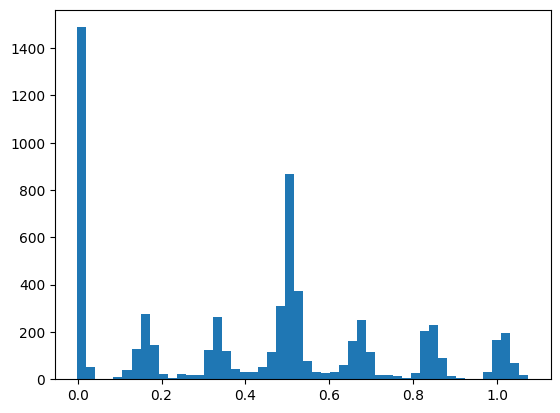

In [123]:
import matplotlib.pyplot as plt
plt.hist(y_pred.flatten(), bins=50)

In [124]:
for layer in model.layers:
    if layer.trainable_variables:  # Check if the layer has trainable variables
        for i, var in enumerate(layer.trainable_variables):
            print(f"{layer.name} - Variable {i} ({var.name}): values: {var.numpy()}")
    else:
        print(layer.name, "has no trainable variables.")

first_layer - Variable 0 (B_1): values: [1.6723859 1.0723083 1.0297962 1.0436304 1.1112401 1.0466756 1.047668
 1.0736018 1.1896466 1.0547267 1.0780443 1.0524778 1.0642873 1.0265588
 1.0414314 0.9948413]
first_layer - Variable 1 (B_2): values: [1.        1.0455238 1.032533  1.028329  1.0817375 1.0284002 1.0382894
 1.0756637 1.1967983 1.042281  1.0646832 1.0570801 1.0395105 1.0309416
 1.0767908 1.0325639]
first_layer - Variable 2 (bias): values: [-0.04369622  0.15750875  0.02353571 -0.03778159  0.06128626 -0.04620406
  0.04069912  0.03096736  0.01823316  0.02324915  0.09390014  0.04393109
  0.06715152  0.12073916  0.04517895  0.19834115  0.17401844  0.09476621
 -0.03973155 -0.01515612  0.0254927  -0.01058109  0.00109967  0.02258612
  0.00075503  0.0054898   0.04984408 -0.01716691  0.01534438  0.03052239
 -0.01510951  0.02860627]
second_layer - Variable 0 (bias): values: [ 0.06279591  0.09142458  0.08600129  0.06635917  0.09732451  0.06217078
  0.04104561  0.05789851  0.03593937  0.060878

In [125]:
from tensorflow.keras import backend as K
K.clear_session()